# Conditional Neural Processes (CNP).
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
from resum.utilities import plotting_utils_cnp as plotting
from resum.utilities import utilities as utils
from resum.conditional_neural_process import DataGeneration
from resum.conditional_neural_process import DeterministicModel
from torch.utils.tensorboard import SummaryWriter
import shap
import yaml

In [ ]:
with open("../binary-black-hole/settings.yaml", "r") as f:
    config_file = yaml.safe_load(f)

TRAINING_EPOCHS = int(config_file["cnp_settings"]["training_epochs"]) # Total number of training points: training_iterations * batch_size * max_content_points
PLOT_AFTER = int(config_file["cnp_settings"]["plot_after"])
torch.manual_seed(0)
BATCH_SIZE = config_file["cnp_settings"]["batch_size_train"]
FILES_PER_BATCH = config_file["cnp_settings"]["files_per_batch_train"]
target_range = config_file["simulation_settings"]["target_range"]
is_binary = target_range[0] >= 0 and target_range[1] <= 1

path_out = config_file["path_settings"]["path_out"]
version = config_file["path_settings"]["version"]



In [3]:
x_size, y_size = utils.get_feature_and_label_size(config_file)

Data Augmentation in Progress: Applying transformations...


100%|██████████| 934/934 [00:09<00:00, 96.81it/s] 


2025-04-07 12:00:01 Iteration: 0/0, train loss: 0.7758 (vs BCE 0.6957)
2025-04-07 12:00:01, Iteration: 0, test loss: 0.8315 (vs BCE 0.7188)


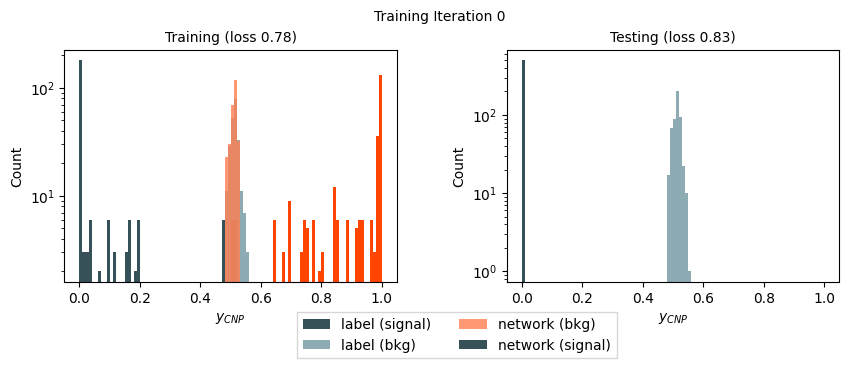

2025-04-07 12:00:18 Iteration: 0/200, train loss: 0.6977 (vs BCE 0.5583)
2025-04-07 12:00:18, Iteration: 200, test loss: 0.8038 (vs BCE 0.6532)


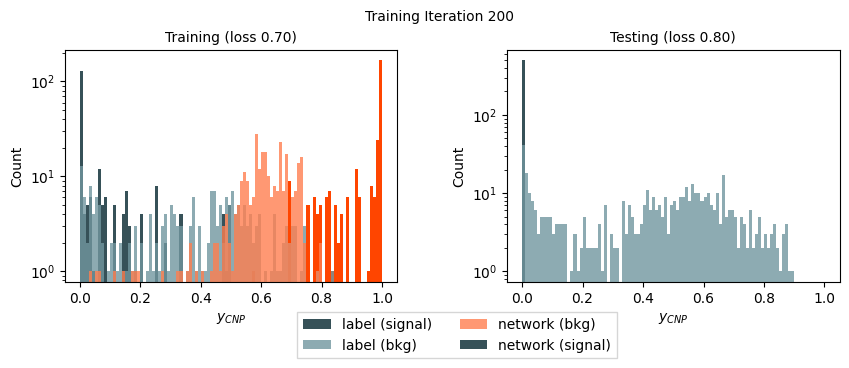

2025-04-07 12:00:40 Iteration: 0/400, train loss: 0.6855 (vs BCE 0.5278)
2025-04-07 12:00:40, Iteration: 400, test loss: 0.7228 (vs BCE 0.4690)


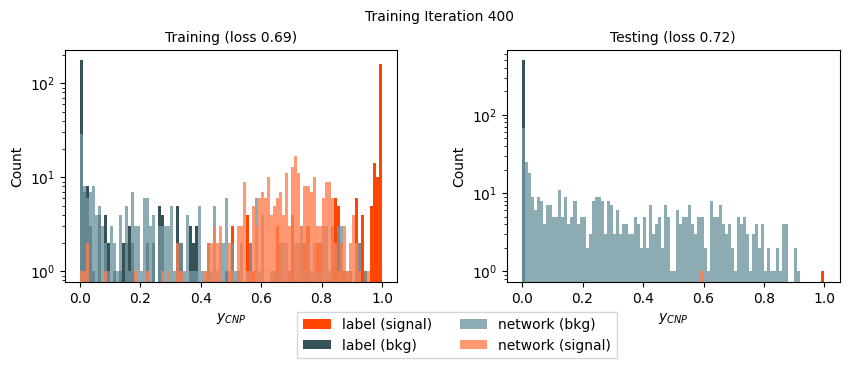

2025-04-07 12:01:00 Iteration: 0/600, train loss: 0.6857 (vs BCE 0.5535)
2025-04-07 12:01:01, Iteration: 600, test loss: 0.7150 (vs BCE 0.4651)


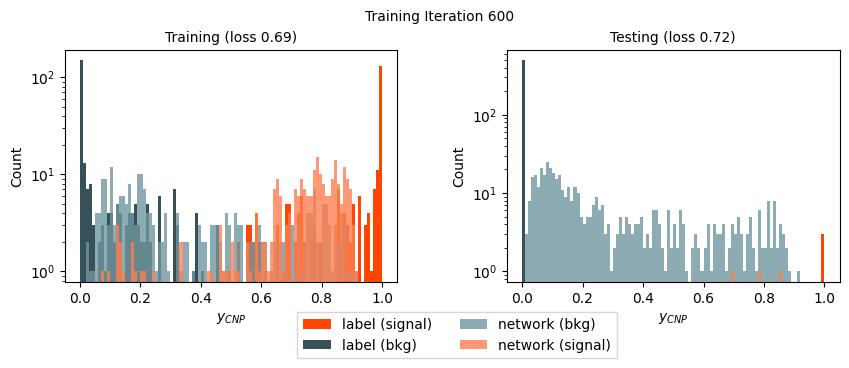

2025-04-07 12:01:17 Iteration: 0/800, train loss: 0.7013 (vs BCE 0.5198)
2025-04-07 12:01:17, Iteration: 800, test loss: 0.6806 (vs BCE 0.3812)


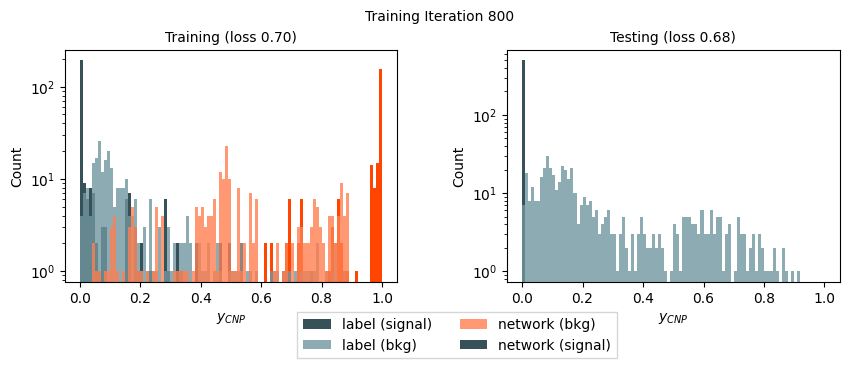

2025-04-07 12:01:34 Iteration: 0/1000, train loss: 0.6497 (vs BCE 0.4412)
2025-04-07 12:01:34, Iteration: 1000, test loss: 0.7189 (vs BCE 0.4934)


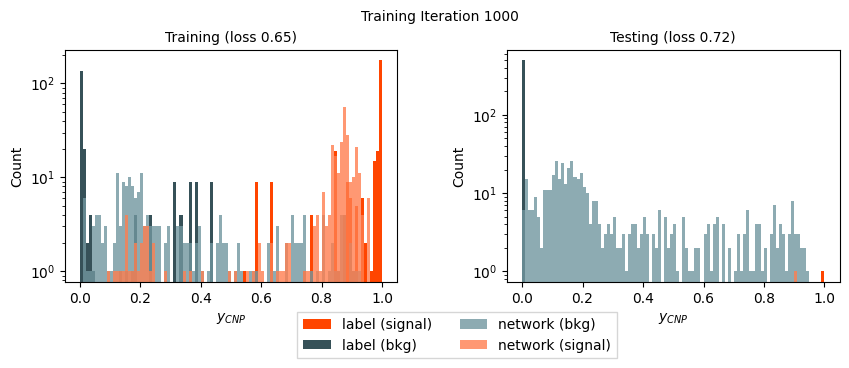

2025-04-07 12:01:51 Iteration: 0/1200, train loss: 0.6426 (vs BCE 0.4234)
2025-04-07 12:01:51, Iteration: 1200, test loss: 0.6201 (vs BCE 0.2384)


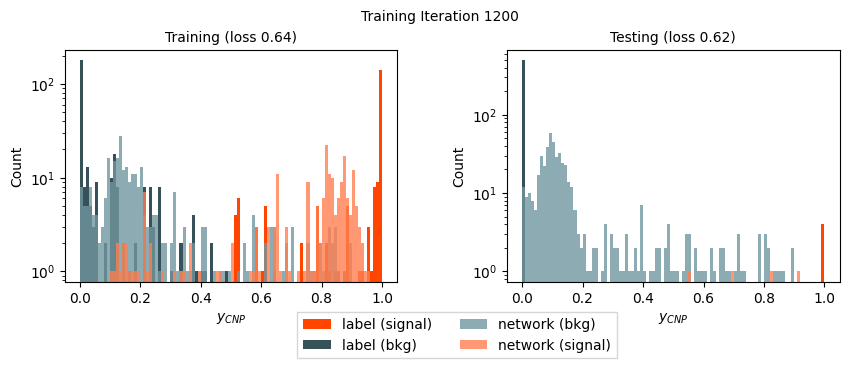

2025-04-07 12:02:08 Iteration: 0/1400, train loss: 0.6392 (vs BCE 0.4021)
2025-04-07 12:02:08, Iteration: 1400, test loss: 0.6484 (vs BCE 0.3232)


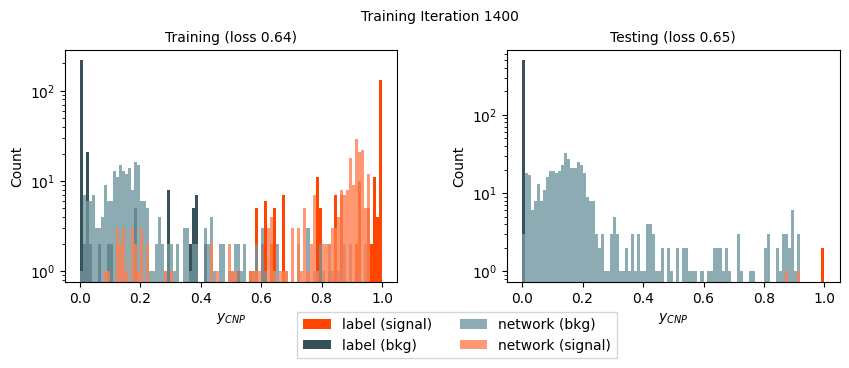

2025-04-07 12:02:24 Iteration: 0/1600, train loss: 0.6443 (vs BCE 0.4316)
2025-04-07 12:02:24, Iteration: 1600, test loss: 0.6611 (vs BCE 0.3623)


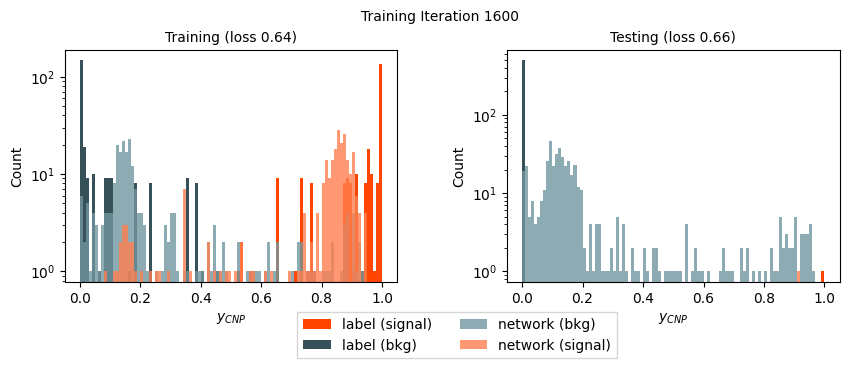

2025-04-07 12:02:41 Iteration: 0/1800, train loss: 0.6372 (vs BCE 0.4154)
2025-04-07 12:02:41, Iteration: 1800, test loss: 0.6387 (vs BCE 0.3033)


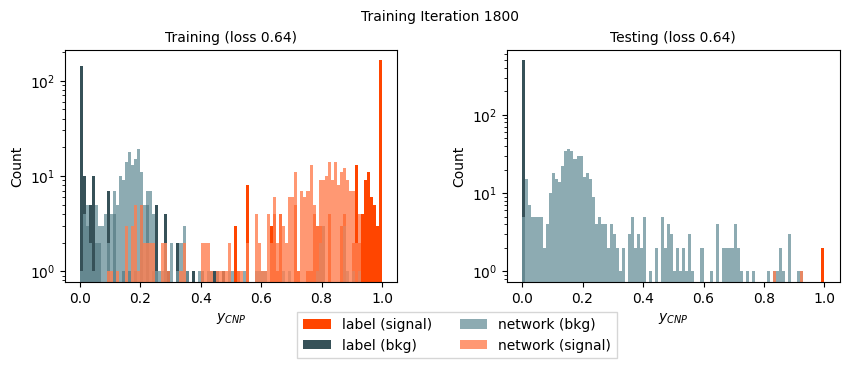

Finished full dataset pass. Starting new epoch! 
Data Augmentation in Progress: Applying transformations...


100%|██████████| 934/934 [00:08<00:00, 109.95it/s]


2025-04-07 12:03:22 Iteration: 1/2000, train loss: 0.6428 (vs BCE 0.4183)
2025-04-07 12:03:22, Iteration: 2000, test loss: 0.6798 (vs BCE 0.3950)


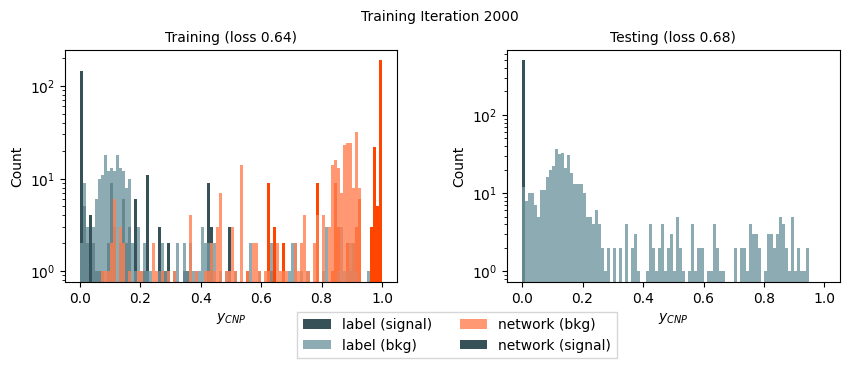

2025-04-07 12:03:41 Iteration: 1/2200, train loss: 0.6406 (vs BCE 0.3930)
2025-04-07 12:03:41, Iteration: 2200, test loss: 0.6489 (vs BCE 0.3201)


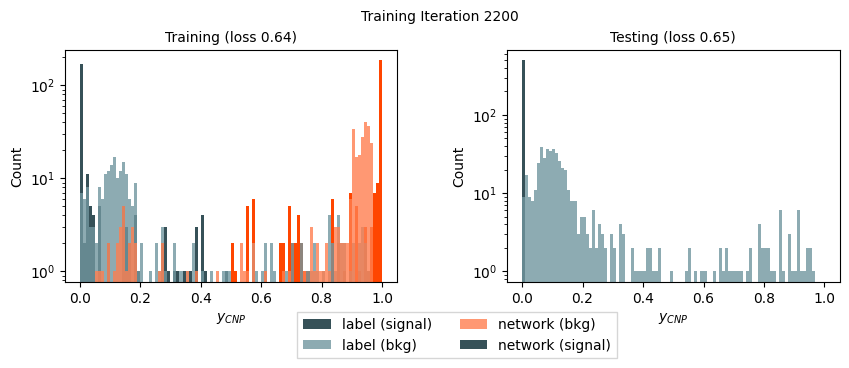

2025-04-07 12:03:59 Iteration: 1/2400, train loss: 0.6451 (vs BCE 0.4529)
2025-04-07 12:03:59, Iteration: 2400, test loss: 0.6298 (vs BCE 0.2769)


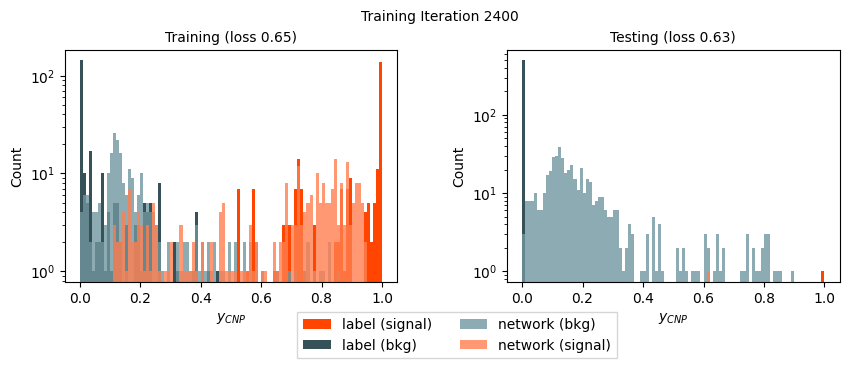

2025-04-07 12:04:18 Iteration: 1/2600, train loss: 0.6289 (vs BCE 0.3879)
2025-04-07 12:04:18, Iteration: 2600, test loss: 0.6342 (vs BCE 0.2767)


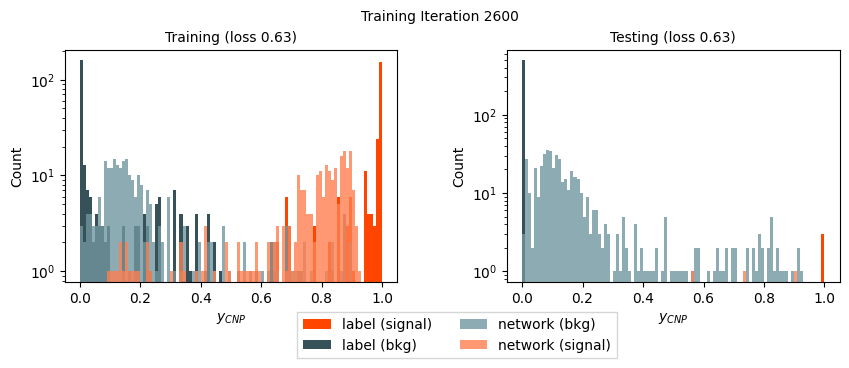

2025-04-07 12:04:35 Iteration: 1/2800, train loss: 0.6123 (vs BCE 0.3198)
2025-04-07 12:04:35, Iteration: 2800, test loss: 0.6234 (vs BCE 0.2378)


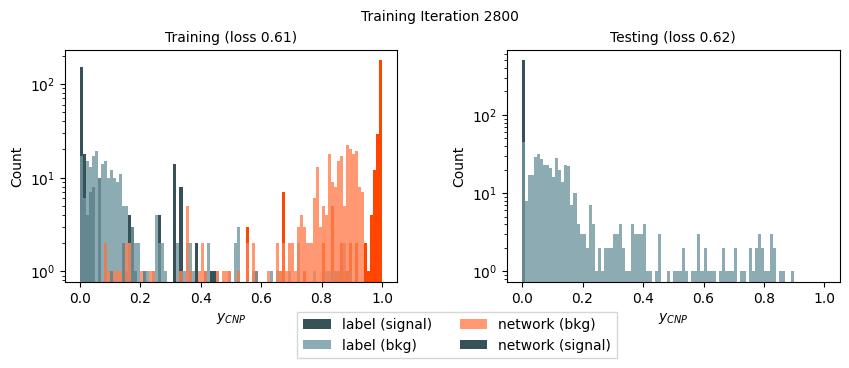

2025-04-07 12:04:53 Iteration: 1/3000, train loss: 0.6307 (vs BCE 0.3796)
2025-04-07 12:04:53, Iteration: 3000, test loss: 0.6478 (vs BCE 0.3115)


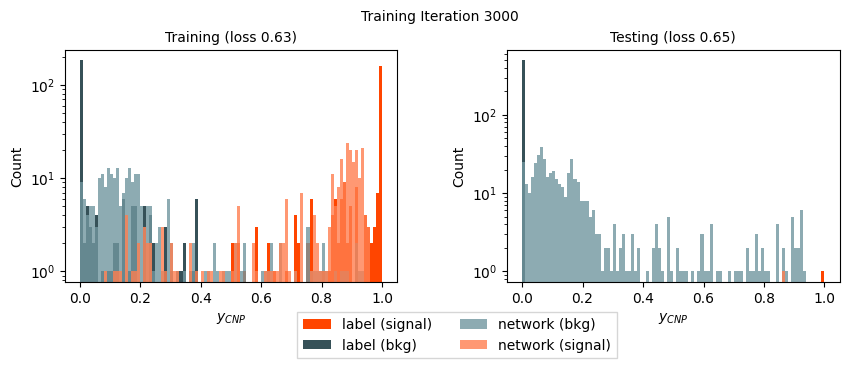

2025-04-07 12:05:10 Iteration: 1/3200, train loss: 0.6457 (vs BCE 0.4405)
2025-04-07 12:05:10, Iteration: 3200, test loss: 0.6333 (vs BCE 0.2740)


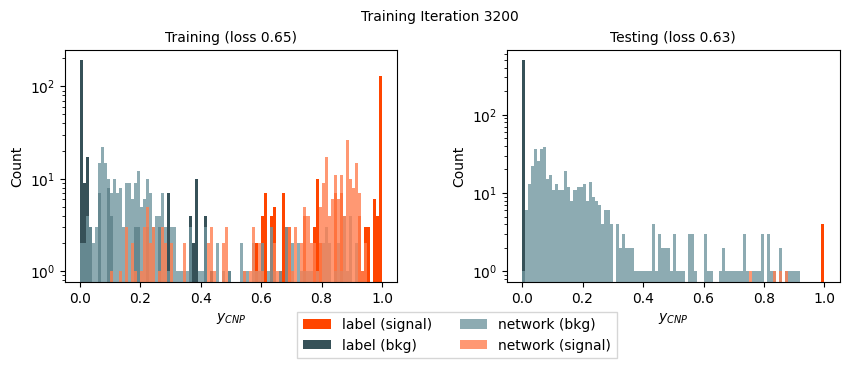

2025-04-07 12:05:27 Iteration: 1/3400, train loss: 0.6236 (vs BCE 0.3600)
2025-04-07 12:05:27, Iteration: 3400, test loss: 0.6226 (vs BCE 0.2409)


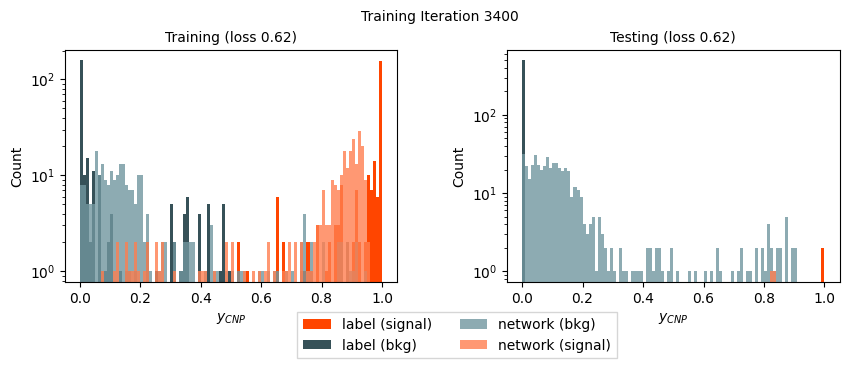

2025-04-07 12:05:44 Iteration: 1/3600, train loss: 0.6237 (vs BCE 0.3518)
2025-04-07 12:05:44, Iteration: 3600, test loss: 0.6270 (vs BCE 0.2476)


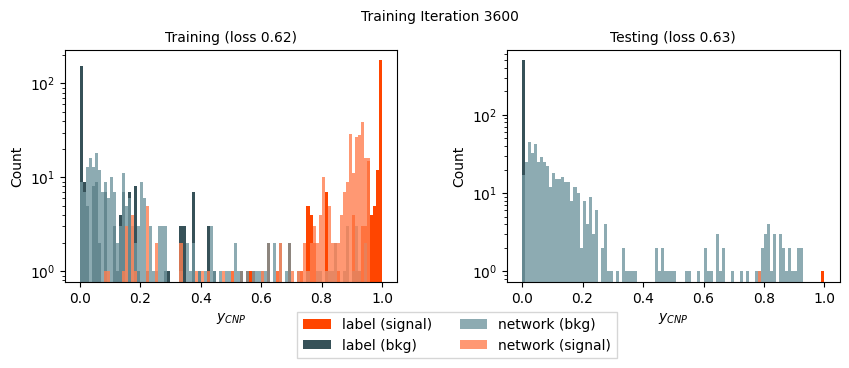

Finished full dataset pass. Starting new epoch! 
Data Augmentation in Progress: Applying transformations...


100%|██████████| 934/934 [00:08<00:00, 107.34it/s]


2025-04-07 12:06:24 Iteration: 2/3800, train loss: 0.6618 (vs BCE 0.4481)
2025-04-07 12:06:24, Iteration: 3800, test loss: 0.6683 (vs BCE 0.3596)


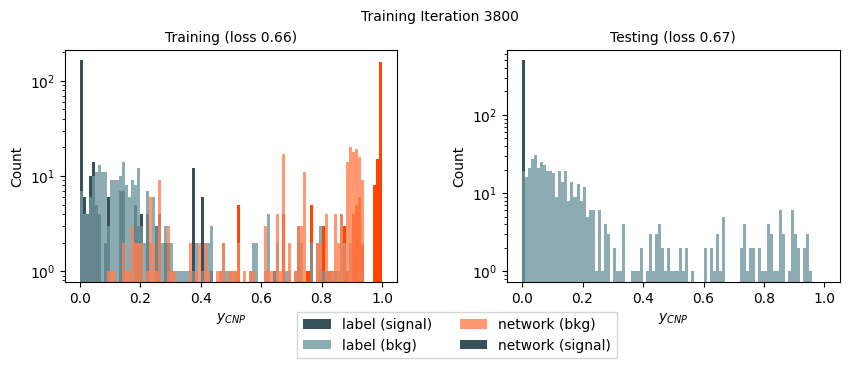

2025-04-07 12:06:41 Iteration: 2/4000, train loss: 0.6283 (vs BCE 0.3727)
2025-04-07 12:06:41, Iteration: 4000, test loss: 0.6167 (vs BCE 0.2192)


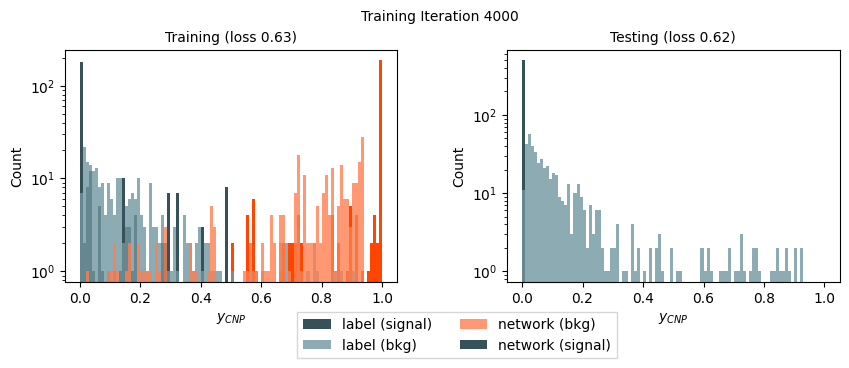

2025-04-07 12:06:58 Iteration: 2/4200, train loss: 0.6249 (vs BCE 0.3745)
2025-04-07 12:06:58, Iteration: 4200, test loss: 0.6412 (vs BCE 0.2838)


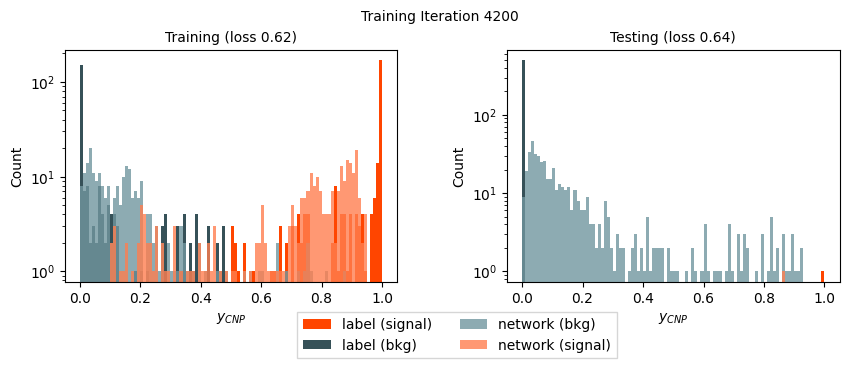

2025-04-07 12:07:16 Iteration: 2/4400, train loss: 0.6383 (vs BCE 0.4104)
2025-04-07 12:07:16, Iteration: 4400, test loss: 0.6331 (vs BCE 0.2669)


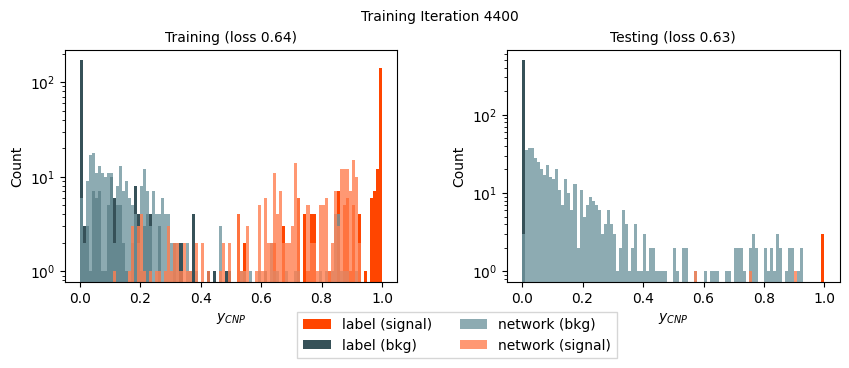

2025-04-07 12:07:33 Iteration: 2/4600, train loss: 0.6513 (vs BCE 0.4450)
2025-04-07 12:07:33, Iteration: 4600, test loss: 0.6261 (vs BCE 0.2568)


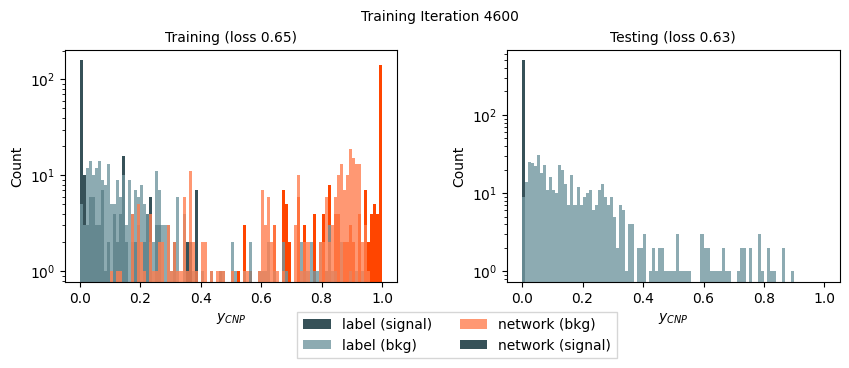

2025-04-07 12:07:50 Iteration: 2/4800, train loss: 0.6323 (vs BCE 0.3887)
2025-04-07 12:07:50, Iteration: 4800, test loss: 0.6431 (vs BCE 0.2860)


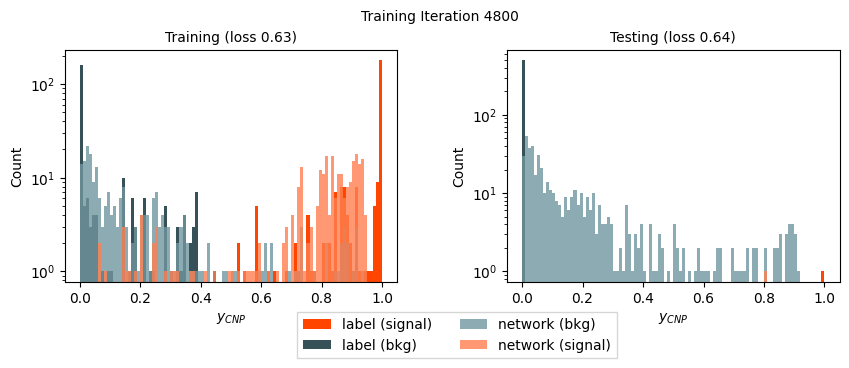

2025-04-07 12:08:06 Iteration: 2/5000, train loss: 0.6379 (vs BCE 0.4100)
2025-04-07 12:08:06, Iteration: 5000, test loss: 0.6555 (vs BCE 0.3245)


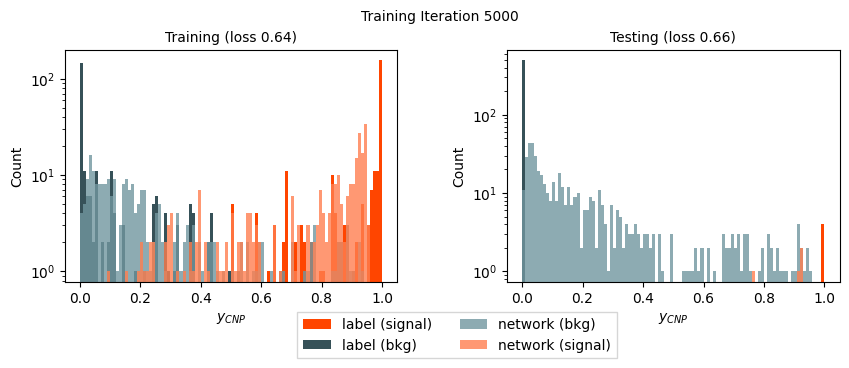

2025-04-07 12:08:24 Iteration: 2/5200, train loss: 0.6265 (vs BCE 0.3458)
2025-04-07 12:08:24, Iteration: 5200, test loss: 0.6442 (vs BCE 0.3044)


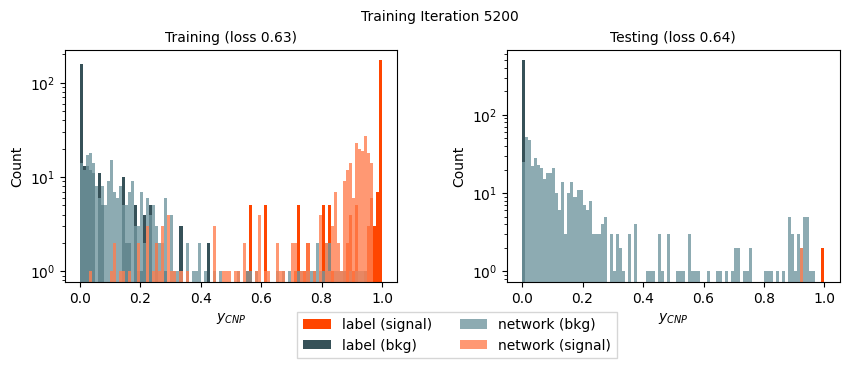

2025-04-07 12:08:40 Iteration: 2/5400, train loss: 0.6504 (vs BCE 0.4482)
2025-04-07 12:08:40, Iteration: 5400, test loss: 0.6488 (vs BCE 0.3104)


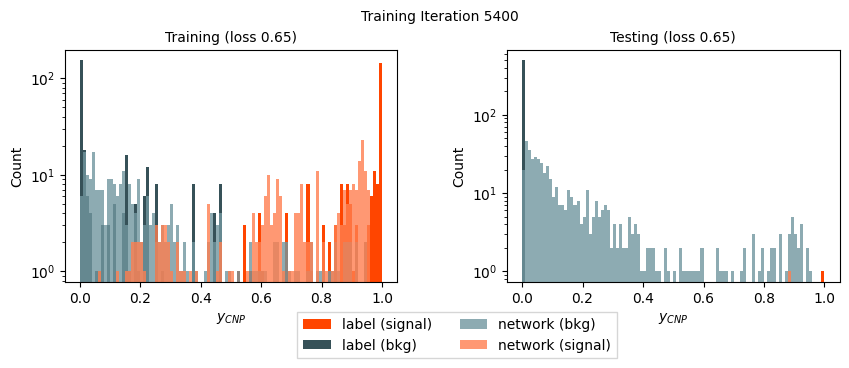

Finished full dataset pass. Starting new epoch! 
Data Augmentation in Progress: Applying transformations...


100%|██████████| 934/934 [00:08<00:00, 116.22it/s]


2025-04-07 12:09:20 Iteration: 3/5600, train loss: 0.6340 (vs BCE 0.4025)
2025-04-07 12:09:20, Iteration: 5600, test loss: 0.6377 (vs BCE 0.2649)


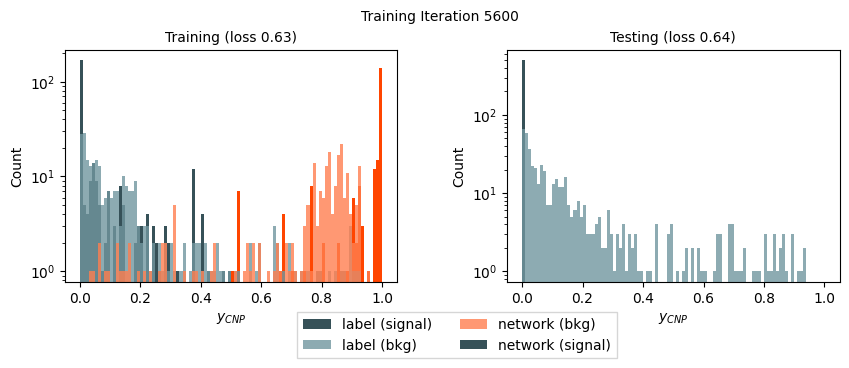

2025-04-07 12:09:36 Iteration: 3/5800, train loss: 0.6435 (vs BCE 0.3952)
2025-04-07 12:09:36, Iteration: 5800, test loss: 0.6429 (vs BCE 0.2959)


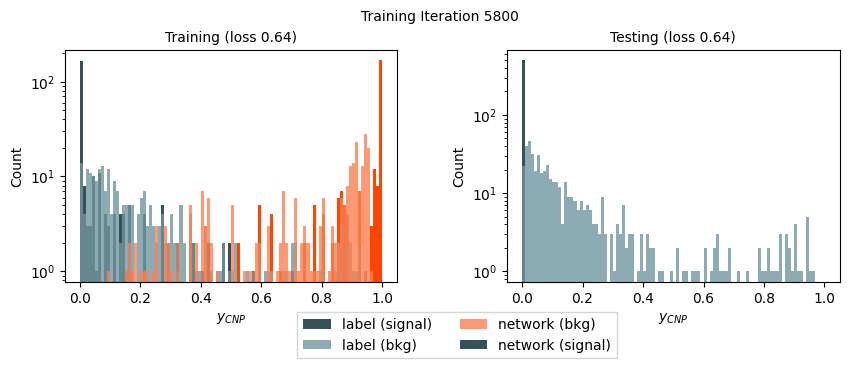

2025-04-07 12:09:53 Iteration: 3/6000, train loss: 0.6121 (vs BCE 0.3196)
2025-04-07 12:09:53, Iteration: 6000, test loss: 0.6363 (vs BCE 0.2589)


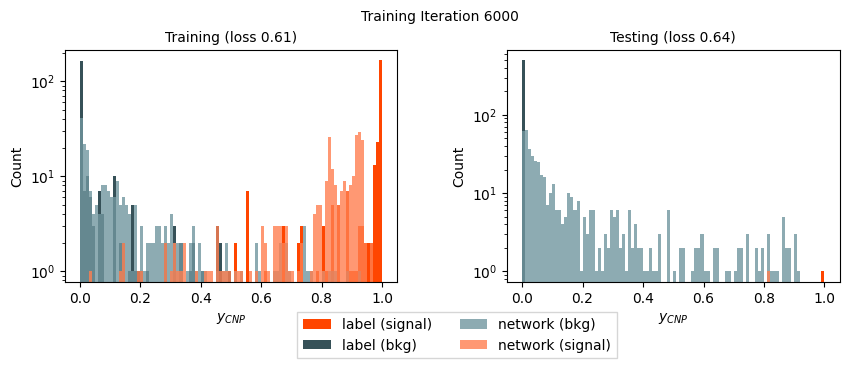

2025-04-07 12:10:10 Iteration: 3/6200, train loss: 0.6516 (vs BCE 0.4308)
2025-04-07 12:10:10, Iteration: 6200, test loss: 0.6807 (vs BCE 0.3942)


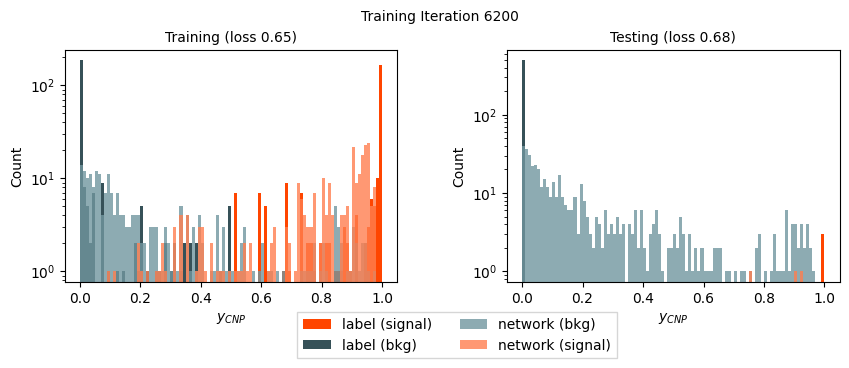

2025-04-07 12:10:27 Iteration: 3/6400, train loss: 0.6158 (vs BCE 0.3767)
2025-04-07 12:10:27, Iteration: 6400, test loss: 0.6626 (vs BCE 0.3414)


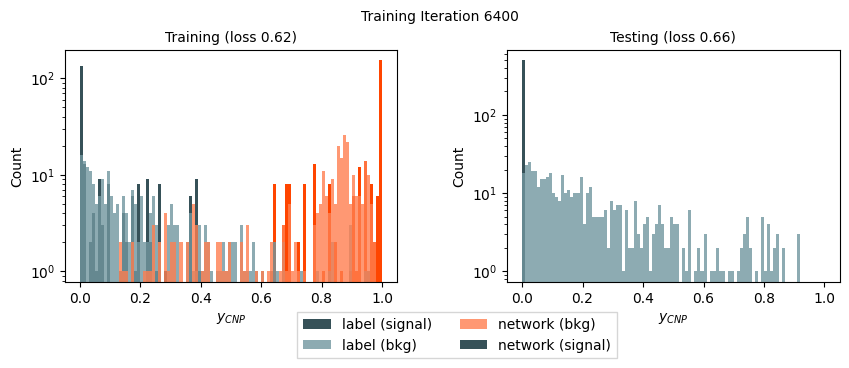

2025-04-07 12:10:44 Iteration: 3/6600, train loss: 0.6178 (vs BCE 0.3369)
2025-04-07 12:10:44, Iteration: 6600, test loss: 0.6557 (vs BCE 0.3180)


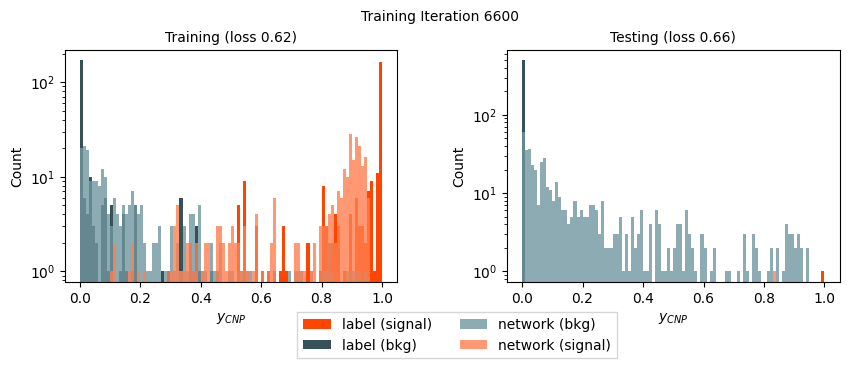

2025-04-07 12:11:01 Iteration: 3/6800, train loss: 0.6171 (vs BCE 0.3192)
2025-04-07 12:11:01, Iteration: 6800, test loss: 0.6375 (vs BCE 0.2680)


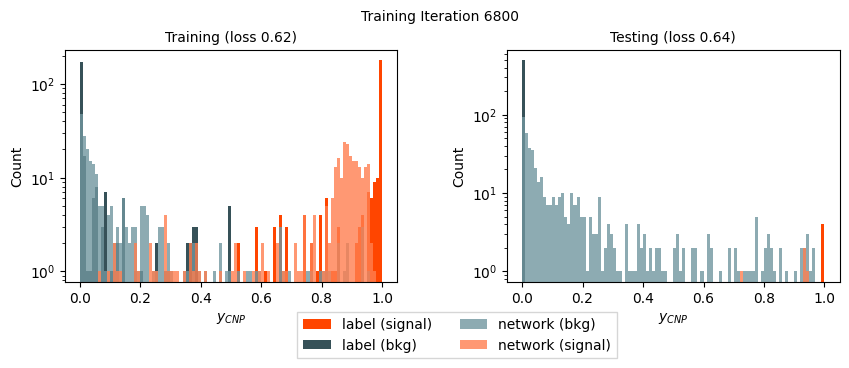

2025-04-07 12:11:17 Iteration: 3/7000, train loss: 0.6263 (vs BCE 0.3701)
2025-04-07 12:11:17, Iteration: 7000, test loss: 0.6569 (vs BCE 0.3346)


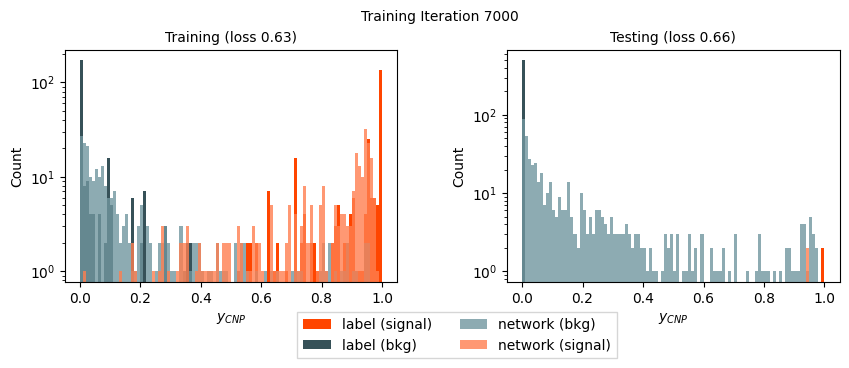

2025-04-07 12:11:34 Iteration: 3/7200, train loss: 0.6239 (vs BCE 0.3490)
2025-04-07 12:11:34, Iteration: 7200, test loss: 0.6427 (vs BCE 0.2788)


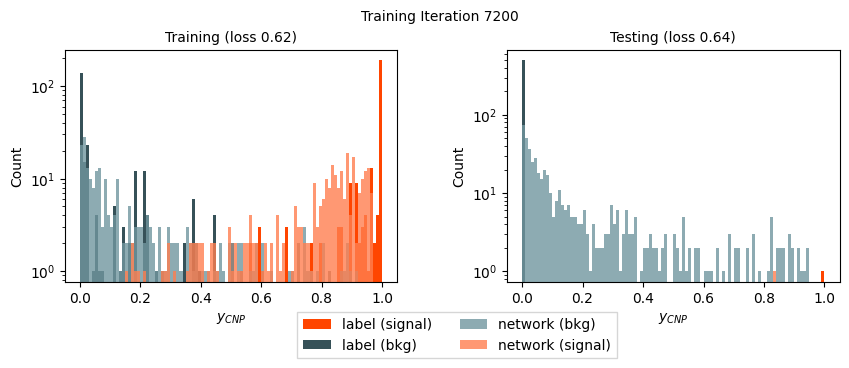

Finished full dataset pass. Starting new epoch! 
Data Augmentation in Progress: Applying transformations...


100%|██████████| 934/934 [00:08<00:00, 114.63it/s]


2025-04-07 12:12:13 Iteration: 4/7400, train loss: 0.6347 (vs BCE 0.3939)
2025-04-07 12:12:13, Iteration: 7400, test loss: 0.7224 (vs BCE 0.5153)


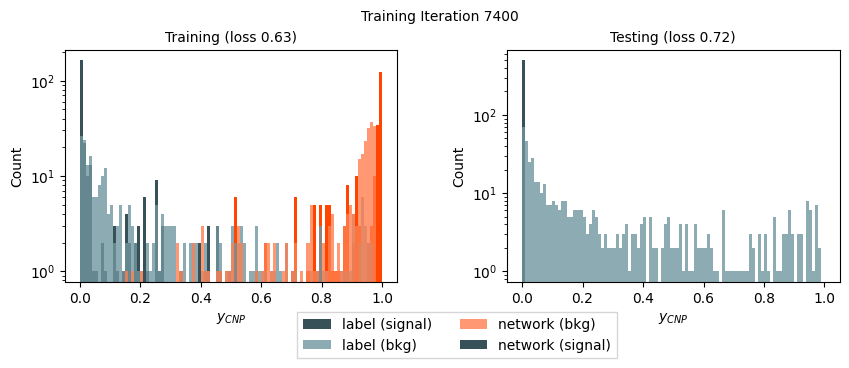

2025-04-07 12:12:26 Iteration: 4/7600, train loss: 0.6351 (vs BCE 0.3797)
2025-04-07 12:12:27, Iteration: 7600, test loss: 0.6319 (vs BCE 0.2514)


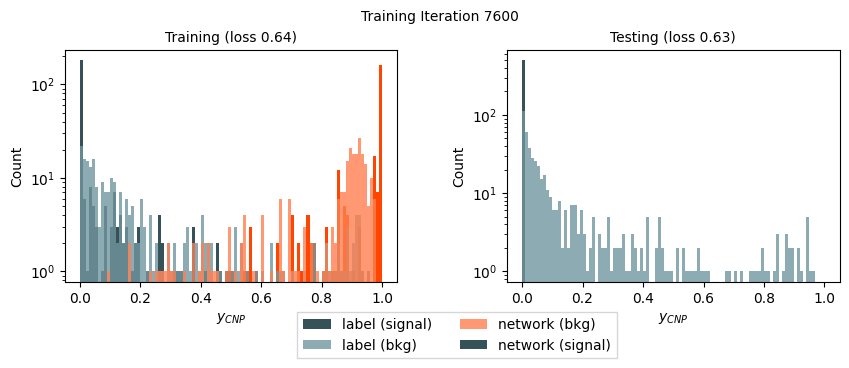

2025-04-07 12:12:44 Iteration: 4/7800, train loss: 0.6263 (vs BCE 0.3520)
2025-04-07 12:12:44, Iteration: 7800, test loss: 0.6843 (vs BCE 0.3835)


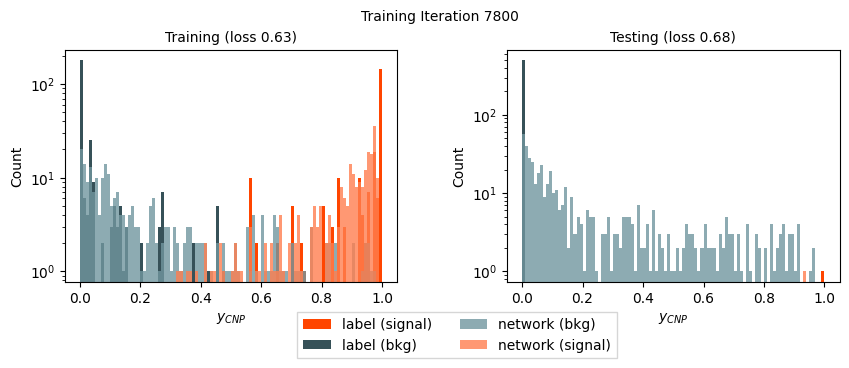

2025-04-07 12:13:01 Iteration: 4/8000, train loss: 0.6141 (vs BCE 0.3116)
2025-04-07 12:13:01, Iteration: 8000, test loss: 0.6814 (vs BCE 0.4024)


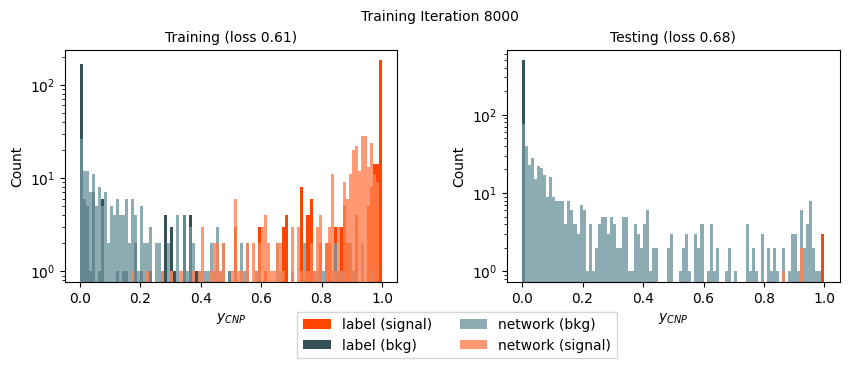

2025-04-07 12:13:17 Iteration: 4/8200, train loss: 0.6166 (vs BCE 0.3182)
2025-04-07 12:13:17, Iteration: 8200, test loss: 0.6558 (vs BCE 0.3054)


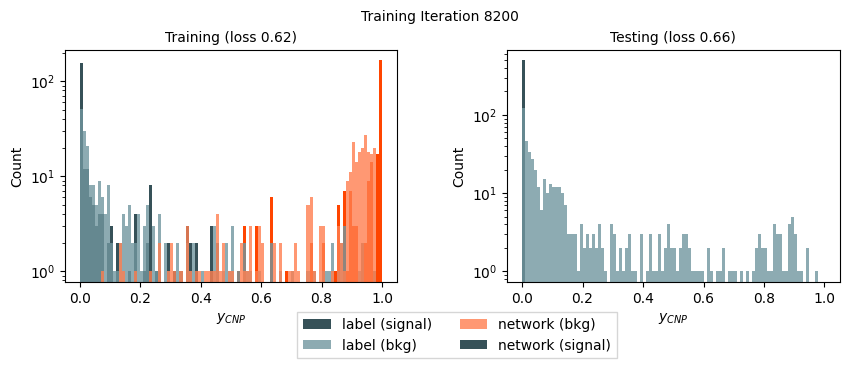

2025-04-07 12:13:35 Iteration: 4/8400, train loss: 0.6225 (vs BCE 0.3694)
2025-04-07 12:13:35, Iteration: 8400, test loss: 0.6248 (vs BCE 0.2257)


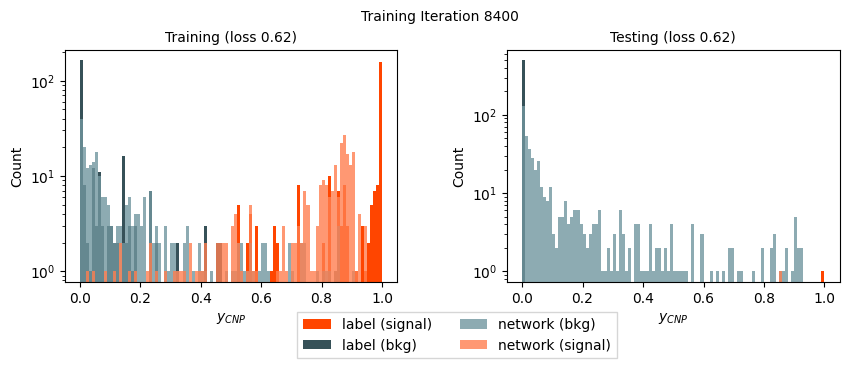

2025-04-07 12:13:51 Iteration: 4/8600, train loss: 0.6285 (vs BCE 0.3657)
2025-04-07 12:13:51, Iteration: 8600, test loss: 0.6449 (vs BCE 0.2813)


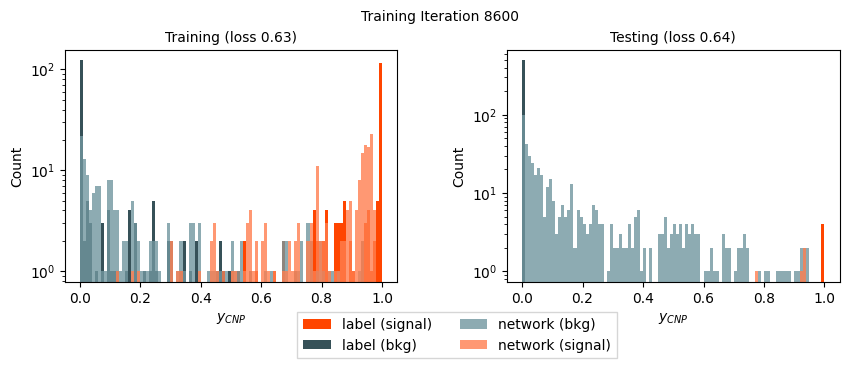

2025-04-07 12:14:08 Iteration: 4/8800, train loss: 0.6412 (vs BCE 0.3963)
2025-04-07 12:14:08, Iteration: 8800, test loss: 0.6384 (vs BCE 0.2684)


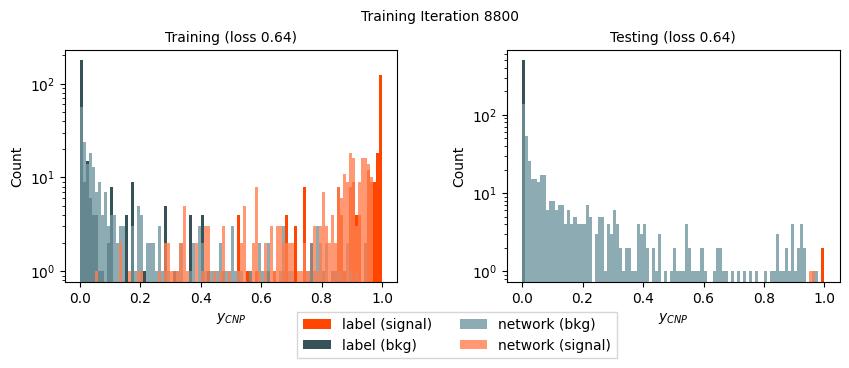

2025-04-07 12:14:24 Iteration: 4/9000, train loss: 0.6277 (vs BCE 0.3572)
2025-04-07 12:14:24, Iteration: 9000, test loss: 0.6286 (vs BCE 0.2270)


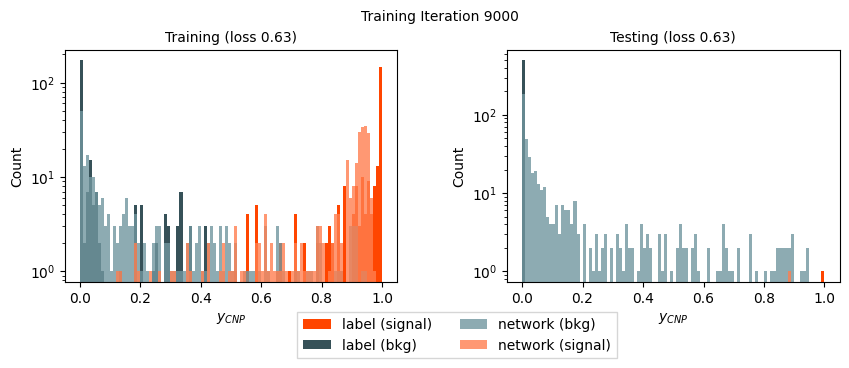

Finished full dataset pass. Starting new epoch! 


In [ ]:

d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size*2
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = DeterministicModel(encoder_sizes, decoder_sizes)
writer = SummaryWriter(log_dir=f'{path_out}/cnp_{version}_tensorboard_logs')

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# 

bce = nn.BCELoss()
iter_testing = 0

# create a PdfPages object
test_idx=0
it_batch = 0
for it_epoch in range(TRAINING_EPOCHS):
    
    USE_DATA_AUGMENTATION = config_file["cnp_settings"]["use_data_augmentation"]
    # load data:
    dataset_train = DataGeneration(mode = "training", 
                                   config_file=config_file, 
                                   path_to_files=config_file["path_settings"]["path_to_training_files"], 
                                   use_data_augmentation=USE_DATA_AUGMENTATION, 
                                   batch_size=BATCH_SIZE,
                                   files_per_batch=FILES_PER_BATCH)
    dataset_train.set_loader()
    dataloader_train = dataset_train.dataloader

    dataset_test = DataGeneration(mode = "training", 
                                  config_file=config_file, 
                                  path_to_files=config_file["path_settings"]["path_to_training_files"], 
                                  use_data_augmentation=False, 
                                  batch_size=BATCH_SIZE,
                                  files_per_batch=FILES_PER_BATCH)
    dataset_test.set_loader()
    dataloader_test = dataset_test.dataloader
    data_iter = iter(dataloader_test)

    #it_batch = 0
    
    for b, batch in enumerate(dataloader_train):
        batch_formated=dataset_train.format_batch_for_cnp(batch,config_file["cnp_settings"]["context_is_subset"] )
        # Get the predicted mean and variance at the target points for the testing set
        log_prob, mu, _ = model(batch_formated.query, batch_formated.target_y, is_binary)
        
        # Define the loss
        loss = -log_prob.mean()
        loss.backward()

        # Perform gradient descent to update parameters
        optimizer.step()
    
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()
        
        if is_binary:
            loss_bce = bce(mu, batch_formated.target_y)
        else:
            loss_bce=-1
        
        # Inside your batch loop, right after computing losses:
        writer.add_scalar('Loss/train_logprob', loss.item(), it_batch)
        if is_binary:
            writer.add_scalar('Loss/train_BCE', loss_bce.item(), it_batch)

        
        mu=mu[0].detach().numpy()
        
        if it_batch % PLOT_AFTER == 0:
            batch_testing = next(data_iter)
            batch_formated_test=dataset_test.format_batch_for_cnp(batch_testing,config_file["cnp_settings"]["context_is_subset"] )
          
            print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),it_epoch, it_batch,loss, loss_bce))
            
            writer.add_scalar('Loss/train_logprob', loss.item(), iter_testing)
            if is_binary:
                writer.add_scalar('Loss/train_BCE', loss_bce.item(), iter_testing)

            log_prob_testing, mu_testing, _ = model(batch_formated_test.query, batch_formated_test.target_y, is_binary)
            loss_testing = -log_prob_testing.mean()
            

            if is_binary:
                loss_bce_testing = bce(mu_testing,  batch_formated_test.target_y)
            else:
                loss_bce_testing = -1.

            writer.add_scalar('Loss/test_logprob', loss_testing.item(), test_idx)
            if is_binary:
                writer.add_scalar('Loss/test_BCE', loss_bce_testing.item(), test_idx)

            mu_testing = mu_testing[0].detach().numpy()
            print("{}, Iteration: {}, test loss: {:.4f} (vs BCE {:.4f})".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it_batch, loss_testing, loss_bce_testing))
            if y_size ==1:
                fig = plotting.plot(mu, batch_formated.target_y[0].detach().numpy(), f'{loss:.2f}', mu_testing, batch_formated_test.target_y[0].detach().numpy(), f'{loss_testing:.2f}', target_range, it_batch)
                writer.add_figure('Prediction/train_vs_test', fig, global_step=test_idx)
            else:
                for k in range(y_size):
                    fig = plotting.plot(mu[:,k], batch_formated.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_testing[:,k], batch_formated_test.target_y[0].detach().numpy()[:,k], f'{loss_testing:.2f}', target_range, it_batch)
                    writer.add_figure(f'Prediction/train_vs_test_k{k}', fig, global_step=test_idx)
            test_idx+=1
    
        it_batch+=1

writer.close()
torch.save(model.state_dict(), f'{path_out}/cnp_{version}_model.pth')
